In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# from sklearn.datasets import load_boston
 
# boston = load_boston()
 
# # 説明変数を読み込む
# X_array = boston.data
# # 目的変数を読み込む
# y_array = boston.target
# # データフレームの作成
# df = pd.DataFrame(X_array, columns = boston.feature_names).assign(Price=np.array(y_array))
# df

In [3]:
# train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 123)
# # 説明変数と目的変数に分ける
# x_train = train_set.drop('Price', axis = 1)
# y_train = train_set['Price']
# x_test = test_set.drop('Price', axis = 1)
# y_test = test_set['Price']
# # LightGBM用のデータセットに入れる
# lgb_train = lgb.Dataset(x_train, y_train)
# lgb.test = lgb.Dataset(x_test, y_test)
# # 評価基準を設定する 
# params = {'metric' : 'rmse'}

In [4]:
# # 訓練データから回帰モデルを作る
# gbm = lgb.train(params, lgb_train)
# # テストデータを用いて予測精度を確認する
# test_predicted = gbm.predict(x_test)
# predicted_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_predicted)], axis = 1)
# predicted_df.columns = ['true', 'predicted']
# # 予測値を図で確認する関数の定義
# def Prediction_accuracy(predicted_df):
#     RMSE = np.sqrt(mean_squared_error(predicted_df['true'], predicted_df['predicted']))
#     plt.figure(figsize = (7,7))
#     ax = plt.subplot(111)
#     ax.scatter('true', 'predicted', data = predicted_df)
#     ax.set_xlabel('True Price', fontsize = 20)
#     ax.set_ylabel('Predicted Price', fontsize = 20)
#     plt.tick_params(labelsize = 15)
#     x = np.linspace(5, 50)
#     y = x
#     ax.plot(x, y, 'r-')
#     plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE,3))),transform = ax.transAxes, fontsize = 15)
# # 予測値を図で確認する
# Prediction_accuracy(predicted_df)

In [5]:
def read_df(path):
    df = pd.read_csv(path, sep=',')
    return df

def extract_train_test_data(df):
    train_df = df[df['year'] == 2019]
    test_df = df[(df['year'] == 2020)]
    # test_df = df[(df['year'] == 2020) & (df['month'] == 8) & (df['day'] == 11)]

    return train_df, test_df

def minxmax_scaler(df, isdf):
    scaler = MinMaxScaler()
    scaler.fit(df)
    if isdf: # 正規化したデータを新規のデータフレームに
        mc = pd.DataFrame(scaler.transform(df), columns=df.columns) 
    else:  # 正規化したデータをリストに
        mc = scaler.fit_transform(df)

    return mc

def make_train_test_data(df, col_list):
    train_df, test_df = extract_train_test_data(df)
    # train_df = train_df[train_df['month']<=8]
    
    # 学習用、テスト用にデータを分割
    # X_train = train_df[col_list]
    X_train = train_df.drop(['datetime', 'temperature'], axis=1)
    y_train = train_df['temperature']
    
    # X_test = test_df[col_list]
    X_test = test_df.drop(['datetime', 'temperature'], axis=1)
    y_test = test_df['temperature']

    return X_train, y_train, X_test, y_test

In [6]:
# データ読み込み
df = read_df('20190101-20200829-takamatsu.csv')
df

,datetime,temperature,pressure,relative_humidity,wind_speed,rainfall,sea_level_pressure,day_length,year,month,day,hour
0,2019-01-01,0.8,1030.3,81.0,1.4,0.0,1031.7,0.0,2019,1,1,1
1,2019-01-01,0.3,1029.8,85.0,1.4,0.0,1031.2,0.0,2019,1,1,2
2,2019-01-01,0.8,1030.0,81.0,2.8,0.0,1031.4,0.0,2019,1,1,3
3,2019-01-01,0.1,1028.8,82.0,0.8,0.0,1030.2,0.0,2019,1,1,4
4,2019-01-01,0.0,1028.0,84.0,0.7,0.0,1029.4,0.0,2019,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
14563,2020-08-29,31.8,1009.0,66.0,0.6,0.0,1010.2,0.0,2020,8,29,20
14564,2020-08-29,30.3,1009.7,76.0,2.2,0.0,1010.9,0.0,2020,8,29,21
14565,2020-08-29,30.1,1009.9,76.0,1.6,0.0,1011.1,0.0,2020,8,29,22
14566,2020-08-29,29.6,1009.8,74.0,1.7,0.0,1011.0,0.0,2020,8,29,23


In [7]:
# 学習、検証データ作成
col_list = ['relative_humidity', 'pressure', 'day_length', 'month', 'day', 'hour']
X_train, y_train, X_test, y_test = make_train_test_data(df, col_list)
display(X_train)
display(y_train)
display(X_test)
display(y_test)

,pressure,relative_humidity,wind_speed,rainfall,sea_level_pressure,day_length,year,month,day,hour
0,1030.3,81.0,1.4,0.0,1031.7,0.0,2019,1,1,1
1,1029.8,85.0,1.4,0.0,1031.2,0.0,2019,1,1,2
2,1030.0,81.0,2.8,0.0,1031.4,0.0,2019,1,1,3
3,1028.8,82.0,0.8,0.0,1030.2,0.0,2019,1,1,4
4,1028.0,84.0,0.7,0.0,1029.4,0.0,2019,1,1,5
...,...,...,...,...,...,...,...,...,...,...
8755,1025.0,59.0,3.5,0.0,1026.3,0.0,2019,12,31,20
8756,1025.5,66.0,2.7,0.0,1026.8,0.0,2019,12,31,21
8757,1025.8,64.0,3.1,0.0,1027.1,0.0,2019,12,31,22
8758,1025.9,63.0,2.8,0.0,1027.2,0.0,2019,12,31,23


0       0.8
1       0.3
2       0.8
3       0.1
4       0.0
       ... 
8755    6.1
8756    5.9
8757    5.7
8758    5.7
8759    5.4
Name: temperature, Length: 8760, dtype: float64

,pressure,relative_humidity,wind_speed,rainfall,sea_level_pressure,day_length,year,month,day,hour
8760,1025.5,66.0,2.9,0.0,1026.8,0.0,2020,1,1,1
8761,1025.5,69.0,2.1,0.0,1026.8,0.0,2020,1,1,2
8762,1025.6,69.0,2.0,0.0,1027.0,0.0,2020,1,1,3
8763,1025.4,73.0,2.1,0.0,1026.8,0.0,2020,1,1,4
8764,1025.4,76.0,2.6,0.0,1026.8,0.0,2020,1,1,5
...,...,...,...,...,...,...,...,...,...,...
14563,1009.0,66.0,0.6,0.0,1010.2,0.0,2020,8,29,20
14564,1009.7,76.0,2.2,0.0,1010.9,0.0,2020,8,29,21
14565,1009.9,76.0,1.6,0.0,1011.1,0.0,2020,8,29,22
14566,1009.8,74.0,1.7,0.0,1011.0,0.0,2020,8,29,23


8760      4.5
8761      3.9
8762      3.4
8763      2.7
8764      2.3
         ... 
14563    31.8
14564    30.3
14565    30.1
14566    29.6
14567    29.5
Name: temperature, Length: 5808, dtype: float64

In [8]:
# LightGBM用のデータセットに入れる
lgb_train = lgb.Dataset(X_train, y_train)
lgb.test = lgb.Dataset(X_test, y_test)
# 評価基準を設定する 
params = {'metric' : 'rmse'}

In [9]:
# 訓練データから回帰モデルを作る
gbm = lgb.train(params, lgb_train)
# テストデータを用いて予測精度を確認する
test_predicted = gbm.predict(X_test)
predicted_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_predicted)], axis = 1)
predicted_df.columns = ['true', 'pred']
predicted_df

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 9
[LightGBM] [Info] Start training from score 17.373590


,true,pred
0,4.5,4.283309
1,3.9,3.359143
2,3.4,3.212804
3,2.7,2.443436
4,2.3,2.031611
...,...,...
5803,31.8,28.650173
5804,30.3,26.770826
5805,30.1,26.615694
5806,29.6,26.686089


Text(0.1, 30, 'RMSE = 2.665')

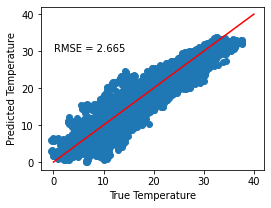

In [10]:
# 予測値を図で確認する
RMSE = np.sqrt(mean_squared_error(predicted_df['true'], predicted_df['pred']))
plt.figure(figsize = (4,3))
plt.scatter(predicted_df['true'], predicted_df['pred'])
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.plot(np.linspace(0, 40), np.linspace(0, 40), 'r-')
plt.text(0.1, 30, 'RMSE = {}'.format(str(round(RMSE,3))), fontsize=10)
# plt.savefig('figure/scatter_lightGBM.png')

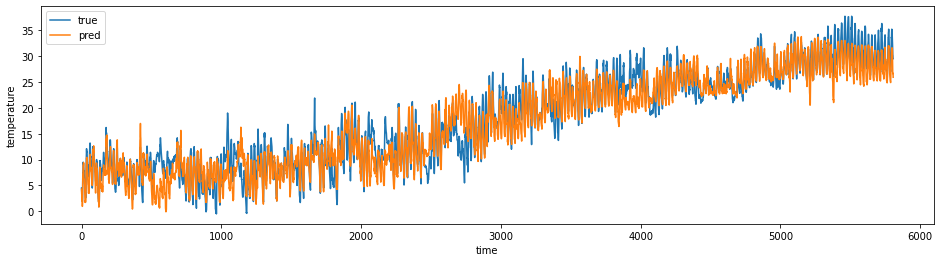

In [11]:
plt.figure(figsize=(16,4))
plt.plot(predicted_df['true'], label='true')
plt.plot(predicted_df['pred'], label='pred')
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()
# plt.xlim(0,1000)
# plt.savefig('figure/pre_lightGBM.png')

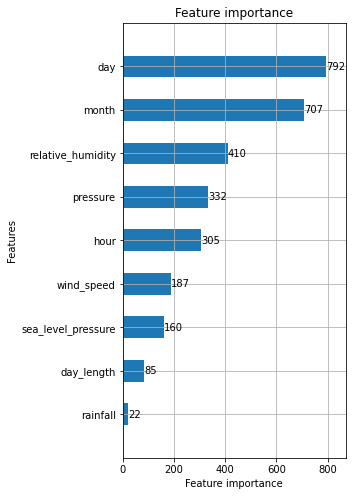

In [12]:
# 特徴量の重要度を確認
lgb.plot_importance(gbm, height = 0.5, figsize = (4,8))
plt.show()
# plt.savefig('figure/feature_importance_lightGBM.png')